In [80]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Layer, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [81]:
# ---------------------- 1. Preprocessing (Tokenization) ----------------------
def preprocess_text(texts,tokenizer=None, max_words=10000, max_len=300):
    """
    Tokenizes and pads the input text data.

    Args:
        texts (pd.Series): A pandas Series containing the text data.
        max_words (int): The maximum number of words to keep in the vocabulary.
        max_len (int): The maximum length of each sequence.

    Returns:
        tuple: A tuple containing the tokenized and padded sequences (numpy array)
               and the fitted Tokenizer object.
    """
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
        tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded_sequences, tokenizer

In [82]:
# ---------------------- 2. Model Building (LSTM with Attention) ----------------------
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                  shape=(input_shape[-1], 1),
                                  initializer='random_normal',
                                  trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                  shape=(input_shape[1], 1),
                                  initializer='zeros',
                                  trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.tanh(tf.matmul(x, self.W) + self.b)
        at = tf.nn.softmax(tf.squeeze(et, axis=-1))
        at_expanded = tf.expand_dims(at, axis=-1)
        context_vector = x * at_expanded
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

In [83]:
def build_lstm_attention_model(vocab_size, embedding_dim, lstm_units, max_len):
    """
    Builds an LSTM model with an attention mechanism for sentiment analysis.

    Args:
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int): The dimensionality of the embedding layer.
        lstm_units (int): The number of units in the LSTM layer.
        max_len (int): The maximum length of the input sequences.

    Returns:
        tf.keras.Model: The compiled LSTM with Attention model.
    """
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(vocab_size, embedding_dim)(input_layer)
    lstm_layer = LSTM(lstm_units, return_sequences=True)(embedding_layer)
    lstm_dropout = Dropout(0.5)(lstm_layer)
    attention_layer = AttentionLayer()(lstm_dropout)
    output_dropout = Dropout(0.5)(attention_layer)
    output_layer = Dense(1, activation='sigmoid')(attention_layer)
    


    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [84]:
# ---------------------- 3. Model Training ----------------------
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    """
    Trains the given Keras model.

    Args:
        model (tf.keras.Model): The Keras model to train.
        X_train (np.array): Training input data.
        y_train (np.array): Training target data.
        X_val (np.array): Validation input data.
        y_val (np.array): Validation target data.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        tf.keras.callbacks.History: The training history object.
    """
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), verbose=1)
    return history

In [85]:
# ---------------------- 4. Model Evaluation ----------------------
def evaluate_model(model, X_val, y_val):
    """
    Evaluates the trained Keras model on the validation data.

    Args:
        model (tf.keras.Model): The trained Keras model.
        X_val (np.array): Validation input data.
        y_val (np.array): Validation target data.

    Returns:
        tuple: A tuple containing the loss and accuracy on the validation set.
    """
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    return loss, accuracy

In [86]:
# ---------------------- 5. Model Scoring ----------------------
def score_model(model, texts, tokenizer, max_len=300, threshold=0.5):
    """
    Scores new text data using the trained model.

    Args:
        model (tf.keras.Model): The trained Keras model.
        texts (list or pd.Series): A list or pandas Series of text to score.
        tokenizer (Tokenizer): The tokenizer fitted on the training data.
        max_len (int): The maximum length of the input sequences.
        threshold (float): The threshold for classifying sentiment (default 0.5).

    Returns:
        pd.DataFrame: A DataFrame containing the original text, predicted probability,
                      and predicted sentiment (0 or 1).
    """
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    predictions = model.predict(padded_sequences)
    predicted_sentiments = np.where(predictions >= threshold, 1, 0).flatten()
    results_df = pd.DataFrame({'cleaned_text': texts,
                               'predicted_probability': predictions.flatten(),
                               'predicted_sentiment': predicted_sentiments})
    return results_df

In [87]:
# ---------------------- 6. Visualization of Training History ----------------------
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy curves.

    Args:
        history (tf.keras.callbacks.History): The training history object.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'r', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'r', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [10]:
# Assume your data is in a pandas DataFrame called 'df' with columns 'cleaned_text' and 'sentiment'

# Sample DataFrame (replace with your actual data loading)
data = {'cleaned_text': ['This is a great movie!', 'The acting was terrible.', 'I really enjoyed it.', 'Waste of my time.'],
        'sentiment': [1, 0, 1, 0]}
df = pd.DataFrame(data)

In [88]:
X_test_ = pd.read_parquet('output/cleandata/test_data_sample/', engine='pyarrow' )
X_train_ = pd.read_parquet('output/cleandata/train_data_sample/', engine='pyarrow' )
X_val_ = pd.read_parquet('output/cleandata/val_data_sample/', engine='pyarrow' )

In [89]:
## Train

X_text_train = list(X_train_["cleaned_text"])
y_train = np.array(X_train_['sentiment']).astype("int32")# X_train_[["sentiment"]]
X_train, tokenizer = preprocess_text(X_text_train)

## Test

X_text_test = list(X_test_["cleaned_text"])
y_test = np.array(X_test_['sentiment']).astype("int32")# X_train_[["sentiment"]]
X_test, tokenizer = preprocess_text(X_text_test,tokenizer)

## Val

X_text_val = list(X_val_["cleaned_text"])
y_val = np.array(X_val_['sentiment']).astype("int32")# X_train_[["sentiment"]]
X_val, tokenizer = preprocess_text(X_text_val,tokenizer)


In [90]:
X_val.shape

(19937, 300)

In [91]:
# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

422795


In [92]:
# Model parameters
embedding_dim = 256
lstm_units = 128
max_len = 300

In [93]:
# Build the model
model = build_lstm_attention_model(vocab_size, embedding_dim, lstm_units, max_len)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 300, 256)       │   108,235,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 300, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 300, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_8               │ (None, 128)            │           428 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,433,197 (413.64 MB)

 Trainable params: 108,433,197 (413.64 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# Train the model
epochs = 10
batch_size = 64
history = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size)

Epoch 1/10


/home/subha/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 108235520 elements. This may consume a large amount of memory.
  warnings.warn(


5625/5625 ━━━━━━━━━━━━━━━━━━━━ 271s 48ms/step - accuracy: 0.8542 - loss: 0.3232 - val_accuracy: 0.9230 - val_loss: 0.1971
Epoch 2/10
 429/5625 ━━━━━━━━━━━━━━━━━━━━ 4:03 47ms/step - accuracy: 0.9443 - loss: 0.1524

KeyboardInterrupt: 

In [28]:
# Evaluate the model
val_loss, val_accuracy = evaluate_model(model, X_val, y_val)

# Example scoring
new_texts = ["This movie was absolutely fantastic!", "I was so disappointed with this film.", "It was okay, nothing special."]
scoring_results = score_model(model, new_texts, tokenizer, max_len=max_len)
print("\nScoring Results:")
print(scoring_results)

Validation Loss: 0.8483
Validation Accuracy: 0.8641
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

Scoring Results:
                            cleaned_text  predicted_probability  \
0   This movie was absolutely fantastic!               0.989386   
1  I was so disappointed with this film.               0.997171   
2          It was okay, nothing special.               0.800585   

   predicted_sentiment  
0                    1  
1                    1  
2                    1  


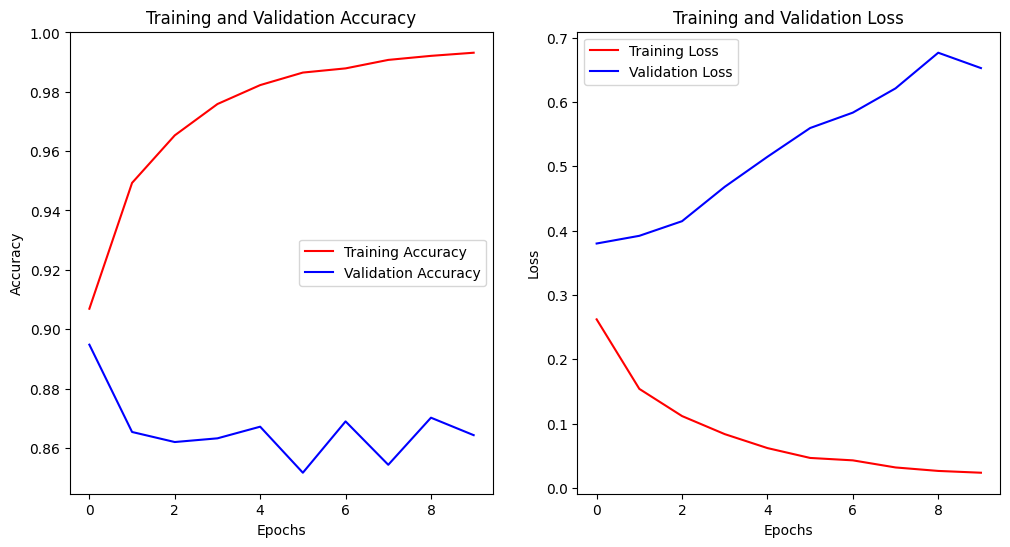

In [79]:
# Plot the training history
plot_training_history(history)